# Trajectories of Taxis

Adrian Sarno, for the Startup.ML Challenge, 2015.12.25.

In this Python script, I explore a dataset containing millions of GPS data points
from taxis in Beijin. The script covers some of the typical tasks in the low-level preprocessing phase of data mining, with the goal of conditioning the data for 
knowledge mining in subsequent phases of a pipeline.


References:
-  Roger Labbe. Kalman and Bayesian Filters in Python.
-  Francis Grovers. Kalman Filters. YouTube.
- Jing Yuan, Yu Zheng, Xing Xie, and Guangzhong Sun. Driving with knowledge from the physical world.
- Jing Yuan, Yu Zheng, Chengyang Zhang, Wenlei Xie, Xing Xie, Guangzhong Sun, and Yan Huang. Tdrive:
driving directions based on taxi trajectories.


In [1]:
%matplotlib inline
import csv
import zipfile
import math
import pandas as pd
import numpy as np
import datetime
from pandas.lib import Timestamp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from geopy.distance import great_circle
from filterpy.kalman import KalmanFilter

In [2]:
print 'requires pandas 0.17.1 or better, your version: ', pd.__version__ 
print 'tested on matplotlib 1.5.0, your version:', matplotlib.__version__ 

requires pandas 0.17.1 or better, your version:  0.17.1
tested on matplotlib 1.5.0, your version: 1.5.1


## Read the Data
Read all the GPS data files contained in the ZIP archive and return a DataFrame

In [3]:
def read_csv(filename, zf):
    df = pd.read_csv(zf.open(filename), header=None, 
                 names=['taxi_id', 'timestamp', 'longitude', 'latitude'], 
                 error_bad_lines=False, delimiter=',', 
                 parse_dates = {'date_time' : ['timestamp']}, index_col=False)
    
    # calculate intervals   
    df['interval'] = df['date_time'] - df['date_time'].shift(1).fillna(0)
    df.set_value(0,'interval', 0)

    df['prev_lon'] = df['longitude'].shift(1).fillna(0)
    df['prev_lat'] = df['latitude'].shift(1).fillna(0)

    dist = lambda r: great_circle((r['prev_lon'], r['prev_lat']),(r['longitude'], r['latitude'])).meters
    df['distance'] = df.apply(dist, axis=1)
    
    # To iterate over 2M rows with apply() calling great_circle_distance is too slow for debugging, 
    # so I estimate with L1:
    #grad2rad = 2 * 3.1416 / 360
    #earthRadius = 6371000; #meters
    #df['distance'] = grad2rad * earthRadius * (abs(df['longitude'].values - df['prev_lon'].values) + abs(df['latitude'].values - df['prev_lat'].values))   
    
    df.set_value(0,'distance', -1)
    
    return df

def read_zip_range(zip_path, f1,f2):
    zf = zipfile.ZipFile(zip_path)        
    frames = [ read_csv(f, zf) for f in zf.namelist()[f1:f2] ]
    return pd.concat(frames)

def read_zip(zip_path):
    zf = zipfile.ZipFile(zip_path)        
    frames = [ read_csv(f, zf) for f in zf.namelist() ]
    return pd.concat(frames)


## Visualize dataset on geographical coordinates
This visualization is not requested in the challenge, but I decided to implement it because of 
it provides a good summary of what the data is about.

In [4]:
# input: x, the logarithm of the actual number we want to show
# output: the actual number (10 ** x), formatted in exponential notation
def fmt(x, pos):
    a, b = '{:.2e}'.format(10**x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

# The output is a matrix (similar to a bitmap) but the content of each  
# cell is the the frequency of observations that fall in each bin
def calc_binmap(latlong, w, h, dpi):
    # trim the tails of the distribution: the GPS points far away from the mean
    lat_low, lat_hgh = np.percentile(latlong[:,0], [2, 98])
    lon_low, lon_hgh = np.percentile(latlong[:,1], [2, 98])
    # Create arrays of evenly spaced numbers over the range of each dimension.
    # to be used a bin edges for the histogram
    lat_bins = np.linspace(lat_low, lat_hgh,  h * dpi) 
    lon_bins = np.linspace(lon_low, lon_hgh,  (w-2) * dpi)
    
    #  returns a bi-dimensional mathix of bin frequency counters, x bin edges, y bin edges
    H2, _, _ = np.histogram2d(latlong[:,0], latlong[:,1], bins=(lat_bins, lon_bins))

    # reverse sequence (negative step) on latitude (canvas y coordinate starts from top)
    # use the log-frequency, add 1 to make log always positive
    binmap = np.log(H2[::-1, :] + 1)
    
    # return the map and the coords of two corners of the map
    return binmap, [lon_low, lon_hgh, lat_low, lat_hgh]  
    
def create_map(latlong):
    # Set canvas size
    w = 12.0  # extra space for colorbar
    h = 10.0 # affects the height of the colorscale, not the plot patch    
    plt.rcParams["figure.figsize"] = (w, h)   # (width, height)
    fig = plt.figure(facecolor='dimgray')
    
    binmap, corners = calc_binmap(latlong, w, h, fig.dpi)
    ax = plt.subplot(1,1,1)
    
    # prevent wrapping of the longitud axis labels
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))    
  
    # cmap is the color map, extent sets the scale of the axis
    plt.imshow(binmap, cmap='hot', extent=corners, aspect='auto')
    
    formatter = ticker.LogFormatter(10, labelOnlyBase=False) 
    cb = plt.colorbar(format=ticker.FuncFormatter(fmt))

    plt.axis('on')
    plt.title('Taxi trip end points')
    plt.savefig("taxi_trip_end_points.png")    

# Histograms Plotting Function
The function below is use to plot the histograms for the time interval and the distance interval.

In [5]:
def histogram(data, unit, title, bin_size, cutoff):
    # filter, project, summarize
    intervals = data/bin_size
    int_low = 0.0
    int_hgh = np.percentile(intervals, [cutoff])  # cut the long end of the tail
    int_bins = np.linspace(int_low, int_hgh, int(int_hgh)+1) 
    y, x = np.histogram(intervals, bins=int_bins)
    y_prop = y / float(len(intervals))
    x_ticks =   range(0, int(int_hgh+2)*bin_size ,2*bin_size)
    
    # print some stats for debugging
    if False:
        print 'int_hgh:', int_hgh
        print 'int_bins:', len(int_bins)
        print 'min=%0.4f  median=%0.4f  mean=%0.4f  max=%0.4f  ' % (np.min(intervals), np.median(intervals), np.mean(intervals), np.max(intervals))
        print 'total count: ', len(intervals)
        print 'bin size:', bin_size
        for i in range(len(int_bins)-1):
            print i, ':', int_bins[i], x_ticks[int(i/2)], y[i]
        print len(int_bins)-1, ':', int_bins[len(int_bins)-1]
    
    #plot
    plt.rcParams["figure.figsize"] = (8.0, 6.0)   # (width, height)    
    plt.title(title)
    plt.xlabel(unit)
    plt.ylabel("proportion")
    plt.xlim(0., int(int_hgh)+2)
    plt.xticks(x_ticks)
    plt.ylim(0., np.max(y_prop + 0.1))
    plt.bar(range(0, len(y_prop)*bin_size, bin_size), y_prop, align='edge', color='red', width=0.9*bin_size)
    plt.show()

# Data Exploration
Load the dataset and plot histograms to find out the distribution over time.

In [ ]:
datapath = "./data/"

# read the whole dataset from zipped archive
taxiDF = read_zip(datapath + '01.zip')
print taxiDF.shape
taxiDF.head(n=5)

In [ ]:
df1 = taxiDF[taxiDF['distance']>-1]
time_intervals = df1['interval'].dt.seconds
histogram(time_intervals, 'seconds', "Sampling Time Interval", 1, 99)    

In [ ]:
distances = df1['distance']
histogram(distances, 'meters', "Sampling Distance", 10, 98)

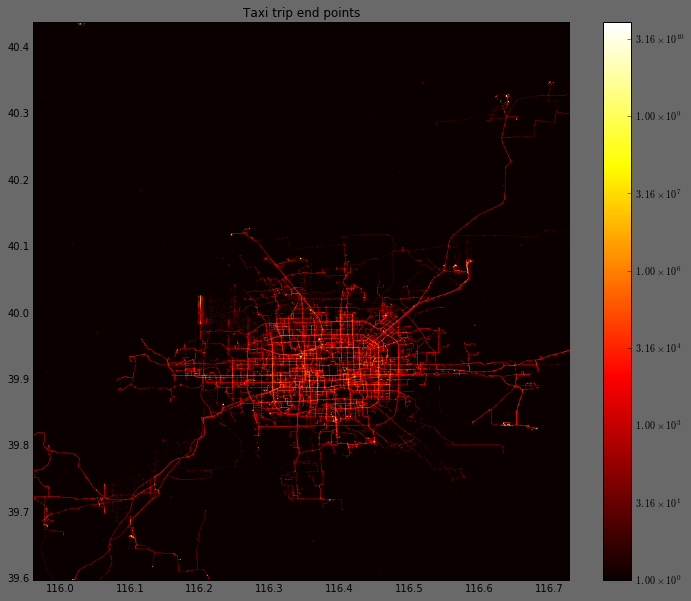

In [9]:
gpsArray = taxiDF.as_matrix(columns=['latitude', 'longitude'])
create_map(gpsArray)

=============================================================================================

# Kalman Smoothing: 
The Kalman filter algorithm applies two processes in each iteration,
the first process predicts the Expected state of the system by aplying a predictive model 
(in the our case is Newton's motion equations, a deterministic model based on acceleration, velocity and position)
 the second process is a correction based on the latest measurements from the sensors 
 (in our case these are latitude and longitud readings from the GPS) and other parameters, 
 like the expected error distribution of the sensors.
 

I will apply the Rauch, Tung, and Striebel algorithm (RTS) which is an application of the
Kalman filtering algorithm for the smoothing scenario, which is the case when you are posprocessing 
 data that has already been sampled, this is different from the control case when you are running the
 algorithm in real time to track a vehicle.
 The difference is that in smothing you can interpolate
 the meassurement values a times t-1 and t+1 to help estimate the value at time t, while in the
 filtering case (real time), you don't have the measurement value at time t+1 at your diposal yet, so you have to extrapolate using t-2 and t-1.
 
RTS is a fixed-interval algorithm, meanning that it makes the simplifying assumption of 
 declaring that the sampling rate is constant, this allows the algorithm to apply a simpler process that does not need to 
include time delta variable in the computation.
The assumption of regular sampling rate is nearly correct when we look at the histogram for a single car. Additionally, if there are some few samples irregularily spaced, the aglorithm will automatically assign a lower trust (Kalman gain) weight for those sampling points. 

 If I would have to deal with a particular sample containing too many irregularily-spaced 
 measurements, I would consider preprocessing the series with a linear or polynomial 
 interpolation to fill in the gaps.

# Model: 
The predition phase model that relates the estate at time t to the state at times t-1 and t+1 is the 
Newton's motion equations involving acceleration, velocity and position.
The only variable that we observe explicitly in our GPS data is position, 
the model will estimate velocity and acceleration as 'hidden'' variables,
and we will enable additional hidden values as explained below.

Since the GPS points correspond to a car driving in a city, most of the data
shows a non-lineal pattern of movement as the car the turns, stops, 
breakes down and accelerates.
 
To prevent the Kalman algorithm from smoothing out the car movement variations as noise, 
I am using a 2nd order dynamic model, this can fit up to the 2nd order derivative of the position, which is the acceleration.  A lower order model can also be used if we assume that the cars travel at constant speed most of the time, this would help filter more noise, 
but probably would not track very accurately in the city (it would approximate with a high bias.)

In [10]:
def kalman_smoother(zs, noise, order, initial_state):
    n = order+1
    fk = KalmanFilter(dim_x=n, dim_z=1)
    fk.x = np.array(initial_state) # initial state:  [x, dx, ...]
    fk.F = np.array(np.triu(np.ones((n,n)), 0)) # state transition matrix
    h = [1.]                    # The measurements track position,
    h.extend(np.zeros(n-1))     # all other state dimensions are hidden (0 means not measured)
    fk.H = np.array([h])        # masurement function
    fk.P = 10.                  # covariance matrix
    fk.R = noise                # state uncertainty (noise in data)
    fk.Q = 0.001                # process uncertainty

    #filter data with Kalman filter, then smooth it
    mu, cov, _, _ = fk.batch_filter(zs)
    M,P,C = fk.rts_smoother(mu, cov)
    
    return M

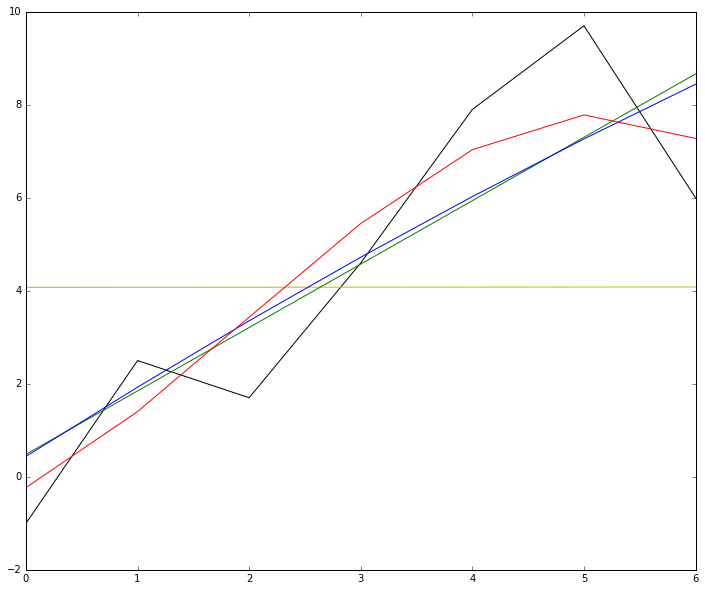

In [11]:
# simulation and tunning of the Kalman smoother
zs = [0. - 1, 2. +.5, 2.-.3,  4.+.6, 8.-.1, 9.+.7, 6.]         
plt.plot(zs, c='black', label='RTS')
color=['y','g','b','r']

# how noisy do I believe the data may be
noise = 7.
for order in range(4):
    initial_state = np.zeros(order+1)
    M = kalman_smoother(zs, noise, order, initial_state)

    # plot results
    index=0  # position is index zero of the state vector
    plt.plot(M[:, index], c=color[order], label='RTS')

# Data for Trajectory
The histogram for taxi 9109 reveals a regular sampling interval of 5 seconds. 
We can also observe the occurrence of a small number of samplings (under 5%) 
taken at 0, 10 and 15 seconds, which are all multiple of 5, suggesting that 
some GPS readings have been skipped and others have been duplicated.

I will smooth out the 2 gps coordinates independently of each other, by running the Kalman smoother for longitud data points (a 1-dimensional space) and also run it separately for latitud.

For simplicity, I will use the unaltered latitud and longitud reading in degrees and rectangular coordinates.

The first 4 most significant digits of the GPS cordinates never change, because the taxis are travelling inside a relatively small area of the planet. 
In a real application we could apply some sort of data compression on the coordinates, so that we can work only with the range of the latitude and longitude values that are relevant for the Beijin region.

For simplicity, I will just substract 39 and 115 from the latitude and longitude values when I want to show a zoomed-in view of the data points.



In [12]:
taxi9109DF = read_zip_range(datapath + '01.zip', 1, 2)
print taxi9109DF.shape
taxi9109DF.head(n=5)

(77554, 8)


,date_time,taxi_id,longitude,latitude,interval,prev_lon,prev_lat,distance
0,2008-02-02 13:30:58,9109,116.35408,39.86716,00:00:00,0.00000,0.00000,-1.000000
1,2008-02-02 13:31:03,9109,116.35522,39.86732,00:00:05,116.35408,39.86716,127.043805
2,2008-02-02 13:31:08,9109,116.35633,39.86747,00:00:05,116.35522,39.86732,123.683118
3,2008-02-02 13:31:13,9109,116.35730,39.86763,00:00:05,116.35633,39.86747,108.178371
4,2008-02-02 13:31:18,9109,116.35822,39.86778,00:00:05,116.35730,39.86763,102.595899


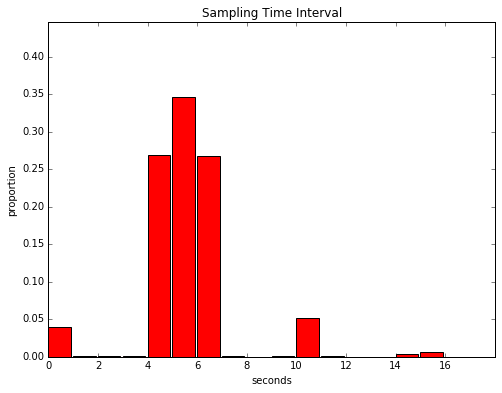

In [13]:
    df2 = taxi9109DF[taxi9109DF['distance']>-1]
    time_intervals = df2['interval'].dt.seconds
    histogram(time_intervals, 'seconds', "Sampling Time Interval", 1, 99)   

In [14]:
def plot_smoothed_coordinate(zs, M, title, ylabel, unit, line_color, initial_skip):
    plt.rcParams["figure.figsize"] = (8.0, 6.0)   # (width, height)    
    plt.title(title)
    plt.xlabel(unit)
    plt.ylabel(ylabel)
    low = np.min(zs[initial_skip:])
    hig = np.max(zs[initial_skip:])
    plt.ylim(low - 0.1*abs(low), hig + 0.1*abs(hig))
    state_variable_to_plot=0 # zero is the position
    #initial_skip: skip first samplings until the smoother settles
    plt.plot(zs[initial_skip:], c='black', label='Data')
    plt.plot(M[initial_skip:, state_variable_to_plot], c=line_color, label='RTS')
    

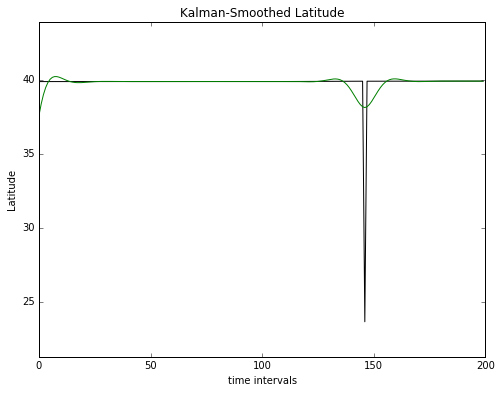

In [19]:
# GPS unidimensional series of readings (lat or long)
# how noisy do I believe the data may be
noise = 1.
order = 2

lat = df2['latitude'][0:200] 
zs = lat.values
initial_state = np.zeros(order+1)

M = kalman_smoother(zs, noise, order, initial_state)
title='Kalman-Smoothed Latitude'
unit='time intervals'
ylabel="Latitude"
plot_smoothed_coordinate(zs, M, title, ylabel, unit, 'g', 0)


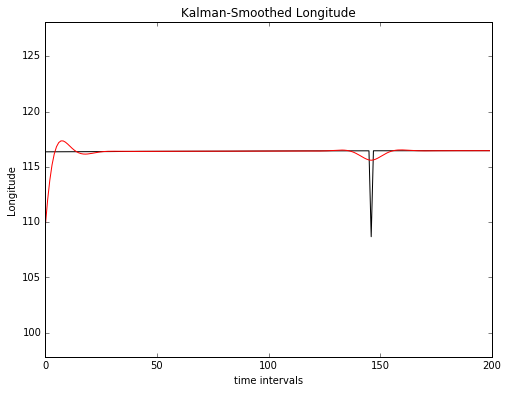

In [20]:
lat = df2['longitude'][0:200] 
zs = lat.values
initial_state = np.zeros(order+1)

M = kalman_smoother(zs, noise, order, initial_state)
title='Kalman-Smoothed Longitude'
unit='time intervals'
ylabel="Longitude"
plot_smoothed_coordinate(zs, M, title, ylabel, unit, 'r', 0)

# Outlier
The data outlier smoothed out above is shown in teh data below

In [21]:
taxi9109DF[145:155]

,date_time,taxi_id,longitude,latitude,interval,prev_lon,prev_lat,distance
145,2008-02-02 13:44:27,9109,116.44488,39.89205,00:00:14,116.44157,39.89212,368.175230
146,2008-02-02 13:44:33,9109,116.44641,39.89208,00:00:06,116.44488,39.89205,170.182659
147,2008-02-02 13:44:55,9109,108.67357,23.65541,00:00:22,116.44641,39.89208,1100569.921054
148,2008-02-02 13:44:57,9109,116.44929,39.89209,00:00:02,108.67357,23.65541,1100843.619769
149,2008-02-02 13:45:03,9109,116.44879,39.89428,00:00:06,116.44929,39.89209,121.916508
150,2008-02-02 13:45:07,9109,116.44879,39.89428,00:00:04,116.44879,39.89428,0.000000
151,2008-02-02 13:45:13,9109,116.44928,39.89204,00:00:06,116.44879,39.89428,123.631593
152,2008-02-02 13:45:13,9109,116.44928,39.89204,00:00:00,116.44928,39.89204,0.000000
153,2008-02-02 13:45:17,9109,116.44928,39.89205,00:00:04,116.44928,39.89204,0.495408
154,2008-02-02 13:45:17,9109,116.44928,39.89205,00:00:00,116.44928,39.89205,0.000000


# Anomaly-free data
Zoom into a section of a few points of data to see how the smoothed curve fits a 
trajectory that does not have any bad data.

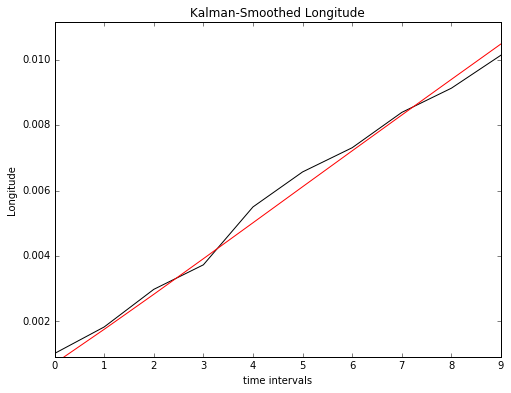

In [22]:
lat = df2['longitude'][0:100] 
zs = (lat.values - 116.42)
initial_state = np.zeros(order+1)

M = kalman_smoother(zs, noise, order, initial_state)
title='Kalman-Smoothed Longitude'
unit='time intervals'
ylabel="Longitude"
plot_smoothed_coordinate(zs, M, title, ylabel, unit, 'r', 90)

# Conclusion
This notebook shows a number of data preprocessing techniques 
applied to GPS data:
- I plot the time sampling histogram to verify whether the 
RTS Kalman smoother assumptions apply.
- Then I design a simple RTS Kalman smoother, with a 2nd degree dynamic
model to process the GPS trajectories.
- I apply the smoother to one section of the data for one of the cars to show 
that it behaves satisfactorily:
    - smoothing out the curve in the case of a large outlier and
    - tracking the data tightly in the case of valid data points.
